Network Architecture


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Building Cortical Thalamic Network
iOut label =  0
Training number  0
iOut label =  0
Training number  1
iOut label =  0
Training number  2
iOut label =  1
Training number  3
iOut label =  1
Training number  4
iOut label =  1
Training number  5
iOut label =  2
Training number  6
iOut label =  2
Training number  7
iOut label =  2
Training number  8
Pre-sleep test initializing...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sleeping Phase


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


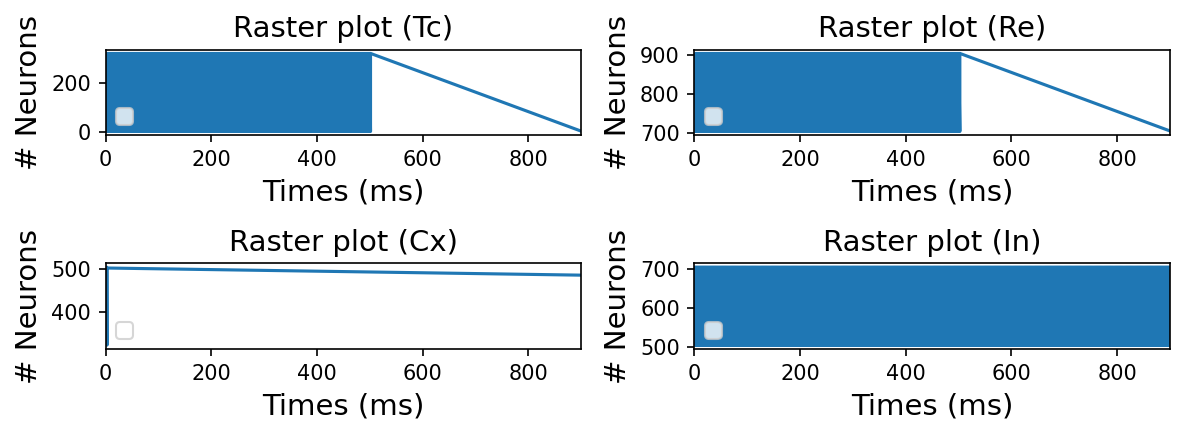

Done!


In [1]:
import nest
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import time
import random
import pylab  #interface de alto nível para matplotlib
import scipy.io as sio # para operações relacionadas a entrada/saída
        
import nest.voltage_trace
import nest.raster_plot
    
nest.set_verbosity("M_WARNING")
nest.ResetKernel()
startbuild = time.time()
#
# Parameter assumed by the network
#Definição de constantes
N_CLASSES = 10
N_RANKS = 3
N_TEST = 250

startTime = time.time()
simtime = 1000.0
#============================= PRE PROCESSING ======================================================================
#
# Pré-processamento do conjunto de dados MNIST.
# são arrays que contêm características (provavelmente extraídas das imagens) 
# do conjunto de treinamento (fn_train) e teste (fn_test), respectivamente.
# "labels_train0" e "labels_test" contêm os rótulos correspondentes 
# (números de 0 a 9) para as imagens no conjunto de treinamento e teste 
#
fn_train = 'mnist_training_features_0.9_14.npy'
feat_arr_train0 = np.load(fn_train)
label_fn_train = 'mnist_training_labels_0.9_14.npy'
labels_train0 = np.load(label_fn_train)
fn_test = 'mnist_test_features_0.9_14.npy'
feat_arr_test = np.load(fn_test)
label_fn_test = 'mnist_test_labels_0.9_14.npy'
labels_test = np.load(label_fn_test)

# Organização dos dados de treinamento por classes
# "feat_train_class" e "label_train_class" são listas que armazenam, respectivamente, 
# características e rótulos agrupados por classe.
feat_train_class=[[] for i in range(N_CLASSES)] # empty 2d list (N_CLASSES x N)
label_train_class=[[] for i in range(N_CLASSES)]
for i in range(len(labels_train0)):
    i_class = labels_train0[i]
    feat_train_class[i_class].append(feat_arr_train0[i])
    label_train_class[i_class].append(i_class)

# Seleção de um subconjunto de dados.
# Um subconjunto de dados (feat_red e labels_red) é selecionado a partir das listas organizadas por classe.
# A seleção é feita com base nas constantes N_CLASSES e N_RANKS.
feat_red = [feat_train_class[i][j] for i in range(N_CLASSES)
            for j in range(0*N_RANKS,(0+1)*N_RANKS)]
labels_red = [label_train_class[i][j] for i in range(N_CLASSES)
              for j in range(0*N_RANKS,(0+1)*N_RANKS)]

# Preparação de dados e ajuste de sementes aleatórias
rand = np.random.RandomState(12345)

# As características (feat_red) e rótulos (labels_red) 
# são convertidos em arrays NumPy para facilitar o manuseio.
feat_arr_train = np.asarray(feat_red)
labels_train = np.asarray(labels_red)

# Os rótulos são convertidos para o tipo de dado inteiro. 
# Isso é comum para garantir que os rótulos sejam interpretados corretamente durante o treinamento 
# ou simulação.
labels_train=labels_train.astype(int)
labels_test=labels_test.astype(int)

# PARAMETERS ======================================================================================================

# Noises
noiseThEx = 30000.0
noiseOut = 10000.0
noiseCxEx = 2000.0 
noiseCxIn = 10000.0
noiseThExRecog = noiseThEx
noiseCxExSleep = 680.

# Weights
W_noiseThEx = 8.0
W_noiseCxEx = 15.0
W_noiseOut = 1.4
W_noiseCxIn = 5.0

W0_CxExThEx = 1.
W0_ThExCxEx = 1.
W0_CxExOut = 0.0001
W0_CxExCxEx = 4.

Wmax_ThExCxEx = 5.50
Wmax_CxExThEx = 135.
Wmax_CxExOut = 154.0
Wmax_CxExCxEx = 150.0

W_CxExCxIn = 60.0
W_CxInCxEx = -4.
W_CxInCxEx_retrieval = -4. 
W_CxInCxIn = -1.
W_CxInCxExSleep = -.7
W_ThExThIn = 10.0
W_ThInThEx = -1.0

# STDP Parameters
muMinus = 1.
muPlus =  1.
alpha = 1.
alphaSleep = 5.
bSleep = 80.

lambda_ThExCxEx = 0.03
lambda_CxExThEx = .08
lambda_CxExOut = .0
lambda_CxExCxEx = 0.09

lambda_ThExCxExSleep = 0.0
lambda_CxExOutSleep = 0.0
lambda_CxExCxExSleep = .000003

# Simulations time
tTrain = 500.0
tPause = 400.0
tCheck = 200.0
tSleep = 600000.

inputSize = 324     # Number of excitatory thalamic neurons
nClasses = N_CLASSES   # Classes division for training task

trainDigit=feat_arr_train
teachOut=labels_train
nTrain = 9

testDigit=feat_arr_train
testOut = labels_train
nTest = 9

# Number of neuron populations
gCxEx = 20                          # Group of cortical excitatory neurons
CxExNeuron = gCxEx*nTrain         # number of cortical excitatory neurons
CxInNeuron = 200
ThExNeuron = inputSize
ThInNeuron = 200
nOut = nClasses

# Input patterns trainPattern and testPattern are arrays receiving trainDigit and testDigit respectively
trainPattern = [[0 for i in range(ThExNeuron)] for j in range(nTrain)] 
for i in range(inputSize):
    for iTrain in range(nTrain):
        trainPattern[iTrain][i] = trainDigit[iTrain][i]

testPattern = [[0 for i in range(ThExNeuron)] for j in range(nTest)]
for i in range(inputSize):
    for iTest in range(nTest):
        testPattern[iTest][i] = testDigit[iTest][i]
#
# Array store the spike populations
nSpikesThEx = [0]*ThExNeuron
cumSpikesThEx = [0]*ThExNeuron    # Cumulative spikes storing of ThEx
nSpikesCxEx = [0]*CxExNeuron
cumSpikesCxEx = [0]*CxExNeuron
nSpikesCxIn = [0]*CxInNeuron
cumSpikesCxIn = [0]*CxInNeuron
nSpikesOut = [0]*nOut
cumSpikesOut = [0]*nOut
nSpikesThIn = [0]*ThInNeuron
cumSpikesThIn = [0]*ThInNeuron

#   Neuron parameters -- first run
vPeak = nest.GetDefaults('aeif_cond_alpha')['V_th']+5*nest.GetDefaults('aeif_cond_alpha')['Delta_T']
b = 0.01
t_ref = 2.0
neuronParams = {'V_peak': vPeak, 'b': b, 't_ref': t_ref}
#
print("Building Cortical Thalamic Network")

# Creating populations
NeuronsThEx = nest.Create("aeif_cond_alpha", ThExNeuron)    # Thalamic excit pop
NeuronsCxEx = nest.Create("aeif_cond_alpha", CxExNeuron)    # Cortical excit pop
NeuronsCxIn = nest.Create("aeif_cond_alpha", CxInNeuron)    # cortical inhib pop
NeuronsThIn = nest.Create("aeif_cond_alpha", ThInNeuron)    # Thalamic inhib pop
NeuronsOut = nest.Create("aeif_cond_alpha", nOut)           # Output neurons - Classes
#    
nest.SetStatus(NeuronsThEx, params = neuronParams)
nest.SetStatus(NeuronsCxEx, params = neuronParams)
nest.SetStatus(NeuronsCxIn, params = neuronParams)
nest.SetStatus(NeuronsThIn, params = neuronParams)
nest.SetStatus(NeuronsOut, params = neuronParams)

# Input noise on the excit thalamic pop
ThExNoise = nest.Create("poisson_generator", ThExNeuron)
synDictNoiseThEx = {"weight": W_noiseThEx, "delay": 1.0}
nest.Connect(ThExNoise, NeuronsThEx, syn_spec=synDictNoiseThEx)
#
# Trainning noise on the excit cortical pop
CxExNoise = nest.Create("poisson_generator", CxExNeuron) 
synDictNoiseCxEx = {"weight": W_noiseCxEx, "delay": 1.0}
nest.Connect(CxExNoise, NeuronsCxEx, syn_spec=synDictNoiseCxEx)

# teaching output noise
OutNoise = nest.Create("poisson_generator", nOut)
synDictNoiseOut = {"weight": W_noiseOut, "delay":1.0} 
nest.Connect(OutNoise, NeuronsOut, syn_spec=synDictNoiseOut)

# Building train exc neuron groups
trainTargetCxEx = [[0 for i in range(gCxEx)] for j in range(nTrain)]
tgt=range(gCxEx)
for iTrain in range(nTrain):
    for i_g in range(gCxEx):
        i = iTrain*gCxEx + i_g
        trainTargetCxEx[iTrain][i_g]=i
#  
#=========== STDP synapses ===================================================================================================================== 
#
# STDP from excitatory thalamic neurons to excitatory cortical neurons
synDictThExCxEx = {"synapse_model" : "stdp_synapse", "lambda": lambda_ThExCxEx, "weight":W0_ThExCxEx, "Wmax": Wmax_ThExCxEx, "delay":1.0}
conn_dict = {'rule': 'pairwise_bernoulli', 'p': 1.0}
nest.Connect(NeuronsThEx, NeuronsCxEx, conn_dict, syn_spec=synDictThExCxEx)
#
# STDP from excitatory cortical neurons to excitatory thalamic neurons 
synDictCxExThEx = {"synapse_model" : "stdp_synapse", "lambda": lambda_CxExThEx, "weight":W0_CxExThEx,
                   "Wmax":Wmax_CxExThEx, "delay":1.0}
nest.Connect(NeuronsCxEx, NeuronsThEx, "all_to_all", syn_spec=synDictCxExThEx)
#
# STDP from excitatory cortical neurons to output 
synDictCxExOut = {"synapse_model" : "stdp_synapse", "lambda": lambda_CxExOut, "weight":W0_CxExOut, 
                  "Wmax":Wmax_CxExOut, "delay":1.0}
nest.Connect(NeuronsCxEx, NeuronsOut, "all_to_all", syn_spec=synDictCxExOut)
#
# STDP from excitatory to excitatory connections
synDictCxExCxEx = {"synapse_model" : "stdp_synapse", "lambda": lambda_CxExCxEx, 
                   "weight": W0_CxExCxEx, "Wmax":Wmax_CxExCxEx}
nest.Connect(NeuronsCxEx, NeuronsCxEx, conn_spec="all_to_all" , syn_spec=synDictCxExCxEx)

#=========================== Synapses non STDP ==================================================================
#
# From excitatory to inhibitory connections
synDictCxExCxIn = {"weight": W_CxExCxIn, "delay":1.0}
nest.Connect(NeuronsCxEx, NeuronsCxIn, conn_spec="all_to_all", syn_spec=synDictCxExCxIn)

# From inhibitory to excitatory connections
synDictCxInCxEx = {"weight": W_CxInCxEx, "delay":1.0}
nest.Connect(NeuronsCxIn, NeuronsCxEx, conn_spec="all_to_all", syn_spec=synDictCxInCxEx)

# From inhibitory to inhibitory
synDictCxInCxIn = {"weight": W_CxInCxIn, "delay":1.0}
nest.Connect(NeuronsCxIn, NeuronsCxIn, conn_spec="all_to_all", syn_spec=synDictCxInCxIn)

# From excitatory thalamical to inhibitory thalamical connections
synDictThExThIn = {"weight": W_ThExThIn, "delay":1.0}
nest.Connect(NeuronsThEx, NeuronsThIn, conn_spec="all_to_all", syn_spec=synDictThExThIn)

# From inhibitory thalamical to excitatory thalamocal connections
synDictThInThEx = {"weight": W_ThInThEx, "delay":1.0}
nest.Connect(NeuronsThIn, NeuronsThEx, conn_spec="all_to_all", syn_spec=synDictThInThEx)

# inhibitory noise
CxInNoise = nest.Create("poisson_generator", CxInNeuron)
synDictNoiseCxIn = {"weight": W_noiseCxIn, "delay":1.0}
nest.Connect(CxInNoise, NeuronsCxIn, syn_spec=synDictNoiseCxIn)

# ================== Multimeters =====================================================

#CxExMult = nest.Create("multimeter")
#CxExMult.set(record_from["V_m"])

#CxInMult =  nest.Create("multimeter")
#CxInMult.set(record_from["V_m"])

#ThExMult = nest.Create("multimeter")
#ThExMult.set(record_from["V_m"])

#ThInMult = nest.Create("multimeter")
#ThInMult.set(record_from["V_m"])
#
#================== Spikes Detectors =====================================================

# Spike detectors for excitatory thalamical pop
SpikeDetecThEx = nest.Create("spike_recorder")
nest.Connect(NeuronsThEx, SpikeDetecThEx)

# Spike detectors for inhibitory thalamic pop
SpikeDetecThIn = nest.Create("spike_recorder")
nest.Connect(NeuronsThIn, SpikeDetecThIn)

# Spike detectors for excitatory cortical pop
SpikeDetecCxEx = nest.Create("spike_recorder")
nest.Connect(NeuronsCxEx, SpikeDetecCxEx)

# Spike detectors for cortical inhibitory neurons
SpikeDetecCxIn = nest.Create("spike_recorder")
nest.Connect(NeuronsCxIn, SpikeDetecCxIn)

# Spike detectors for output
SpikeDetecOut = nest.Create("spike_recorder")
nest.Connect(NeuronsOut, SpikeDetecOut)

for iTrain in range(nTrain):
    iOut = teachOut[iTrain] 
    print("iOut label = ",  iOut)
    print("Training number ", iTrain)
#
    for i in range(ThExNeuron):
        if trainPattern[iTrain][i]==1:
            nest.SetStatus(ThExNoise[i], {"rate": noiseThEx})
        else:
            nest.SetStatus(ThExNoise[i], {"rate": 0.0})

    for i in range(CxExNeuron):
        nest.SetStatus(CxExNoise[i], {"rate": 0.0})

#   Groups of Cortical excitatory neurons receive contextual signal noiseCxEx
    for ig in range(gCxEx): 
            nest.SetStatus(CxExNoise[trainTargetCxEx[iTrain][ig]],
                           {"rate": noiseCxEx})
  
    for i in range(nOut): 
        if i==nOut:
            nest.SetStatus(OutNoise[i], {"rate": noiseOut})
        else:
            nest.SetStatus(OutNoise[i], {"rate": 0.0})

    for i in range(CxInNeuron):
        nest.SetStatus(CxInNoise[i], {"rate": noiseCxIn})

    # Starting training -- "turn on" the weights 
    nest.SetStatus(nest.GetConnections(source=NeuronsThEx, target=NeuronsCxEx), {'lambda': lambda_ThExCxEx})
    nest.SetStatus(nest.GetConnections(source=NeuronsCxEx, target=NeuronsThEx), {'lambda': lambda_CxExThEx})
    nest.SetStatus(nest.GetConnections(source=NeuronsCxEx, target=NeuronsOut), {'lambda': lambda_CxExOut})
    nest.SetStatus(nest.GetConnections(source=NeuronsCxEx, target=NeuronsCxEx), {'lambda': lambda_CxExCxEx})

    # Train simulation
    nest.Simulate(tTrain)
#
    # Post training -- "turn off" the weights
    nest.SetStatus(nest.GetConnections(source=NeuronsThEx, target=NeuronsCxEx), {'lambda': 0.0})
    nest.SetStatus(nest.GetConnections(source=NeuronsCxEx, target=NeuronsThEx),{'lambda': 0.0})
    nest.SetStatus(nest.GetConnections(source=NeuronsCxEx, target=NeuronsOut),{'lambda': 0.0})
    nest.SetStatus(nest.GetConnections(source=NeuronsCxEx, target=NeuronsCxEx), {'lambda': 0.0})
#    
    DfThEx = pd.DataFrame.from_dict(SpikeDetecThEx.get("events")).pivot(index="senders", columns="times", values="times")
    idsThEx = DfThEx.count(axis=1)
#
    DfOut = pd.DataFrame.from_dict(SpikeDetecOut.get("events")).pivot(index="senders", columns="times", values="times")
    idsOut = DfOut.count(axis=1)
#    
    DfCxEx = pd.DataFrame.from_dict(SpikeDetecCxEx.get("events")).pivot(index="senders", columns="times", values="times")
    idsCxEx = DfCxEx.count(axis=1)
#
    DfCxIn = pd.DataFrame.from_dict(SpikeDetecCxIn.get("events")).pivot(index="senders", columns="times", values="times")
    idsCxI = DfCxIn.count(axis=1)
#
    DfThIn = pd.DataFrame.from_dict(SpikeDetecThIn.get("events")).pivot(index="senders", columns="times", values="times")
    idsThIn = DfThIn.count(axis=1)
#
    #switch off all teaching outputs
    for i in range(CxExNeuron):
        nest.SetStatus(CxExNoise[i], {"rate": 0.0})

    for i in range(nOut):
        nest.SetStatus(OutNoise[i], {"rate": 0.0})

    for i in range(CxInNeuron):
        nest.SetStatus(CxInNoise[i], {"rate": noiseCxIn*4})

    for i in range(ThExNeuron):
        nest.SetStatus(ThExNoise[i], {"rate": 0.0})

    nest.Simulate(tPause)

#========================== TESTS =====================================================================    

nest.SetStatus(nest.GetConnections(source=NeuronsCxIn, target=NeuronsCxEx), {"weight": W_CxInCxEx_retrieval})

# switch off all teaching outputs
for i in range(CxExNeuron):
    nest.SetStatus(CxExNoise[i], {"rate": 0.0})

for i in range(nOut):
    nest.SetStatus(OutNoise[i], {"rate": 0.0})

for i in range(CxInNeuron):
    nest.SetStatus(CxInNoise[i], {"rate": noiseCxIn*4})

for i in range(ThExNeuron):
    nest.SetStatus(ThExNoise[i], {"rate": 0.0})

nest.Simulate(tPause*4)

# =========================== PRE SLEEP PHASES STARTING ====================================================
print('Pre-sleep test initializing...')

#test_seq = [2,0,1,3]

ountRight = 0
countUnsupervisedRight =0
for iTest in range(nTest):

    #switch off all teaching outputs
    for i in range(CxExNeuron):
        nest.SetStatus(CxExNoise[i], {"rate": 0.0})

    for i in range(nOut):
        nest.SetStatus(OutNoise[i], {"rate": 0.0})

    for i in range(CxInNeuron):
        nest.SetStatus(CxInNoise[i], {"rate": 0.0})

    #prepare input pattern
    for i in range(CxInNeuron):
        if testPattern[iTest][i]==1:
            nest.SetStatus(ThExNoise[i], {"rate": noiseThExRecog})
        else:
            nest.SetStatus(ThExNoise[i], {"rate": 0.0})

    nest.Simulate(tCheck)
#    
    DfThEx = pd.DataFrame.from_dict(SpikeDetecThEx.get("events")).pivot(index="senders", columns="times", values="times")
    idsThEx = DfThEx.count(axis=1)
#
    DfOut = pd.DataFrame.from_dict(SpikeDetecOut.get("events")).pivot(index="senders", columns="times", values="times")
    idsOut = DfOut.count(axis=1)
#    
    DfCxEx = pd.DataFrame.from_dict(SpikeDetecCxEx.get("events")).pivot(index="senders", columns="times", values="times")
    idsCxEx = DfCxEx.count(axis=1)
#
    DfCxIn = pd.DataFrame.from_dict(SpikeDetecCxIn.get("events")).pivot(index="senders", columns="times", values="times")
    idsCxI = DfCxIn.count(axis=1)
#
    DfThIn = pd.DataFrame.from_dict(SpikeDetecThIn.get("events")).pivot(index="senders", columns="times", values="times")
    idsThIn = DfThIn.count(axis=1)
#
    #switch off all teaching outputs
    for i in range(CxExNeuron):
        nest.SetStatus(CxExNoise[i], {"rate": 0.0})

    for i in range(nOut):
        nest.SetStatus(OutNoise[i], {"rate": 0.0})

    for i in range(CxInNeuron):
        nest.SetStatus(CxInNoise[i], {"rate": noiseCxIn*2})

    for i in range(ThExNeuron):
        nest.SetStatus(ThExNoise[i], {"rate": 0.0})
        
    ThEx_spk = SpikeDetecThEx.get("events")
    ThEx_senders = ThEx_spk["senders"]
    ThEx_times = ThEx_spk["times"]
    
    ThIn_spk = SpikeDetecThIn.get("events")
    ThIn_senders = ThIn_spk["senders"]
    ThIn_times = ThIn_spk["times"]
    
    CxEx_spk = SpikeDetecCxEx.get("events")
    CxEx_senders = CxEx_spk["senders"]
    CxEx_times = CxEx_spk["times"]
    
    CxIn_spk = SpikeDetecCxIn.get("events")
    CxIn_senders = CxIn_spk["senders"]
    CxIn_times = CxIn_spk["times"]

    nest.Simulate(tPause)

#    nSpikesMax = 0
#    iOut = -1
#    for i in range(nOut):
#        nSpikes = nSpikesOut[i];
#        if nSpikes > nSpikesMax:
#            iOut = i
#            nSpikesMax = nSpikes

#    print('Output class index: ', iOut)
#    print('Target class index: ', testOut[iTest])
#    if iOut == testOut[iTest]:
#        countRight = countRight + 1
#    print('Corrects: ', countRight, '/', iTest+1)
#    print('Accuracy = ', float(countRight)/float(iTest+1.)*100., '%')
    
#    nSpikesMaxCxEX = 0
#    iOutExc = -1
#    for i in range(CxExNeuron):
#        nSpikes = nSpikesCxEx[i];
#        if nSpikes > nSpikesMaxCxEX:
#            iOutCxEX = i
#            nSpikesMaxCxEX = nSpikes
#    class_out_exc = np.floor(i_out_exc/(k_exc*N_RANKS))

#    if classOutExc==testOut[iTest]:
#        countUnsupervisedRight = countUnsupervisedRight + 1
        
#    print('Corrects: ', countUnsupervisedRight, '/', iTest+1)
#    print('Accuracy = ', float(countUnsupervisedRight)/float(iTest+1.)*100., '%')
    
#    endTime = time.time()
#    print('Simulation time: %.2f s') % (endTime-startTime)
#    sys.stdout.flush()

#AccuracyPreSleep = float(countRight)/float(iTest+1.)*100.
#AccuracyPreSleepUnsupervised = float(countUnsupervisedRight)/float(iTest+1.)*100.

#connPar=nest.GetConnections(CxExNeuron, CxExNeuron)
#wPreSleep=nest.GetStatus(conn_par, ["source", "target", "weight"])

#connPar_ThExCxEX = nest.GetConnections(ThExNeuron, CxExNeuron)
#w_ThExCxEx = nest.GetStatus(connPar_ThExCxEX, ["source","target","weight"])

#============================= SLEEPING PHASE =============================================================================
print('Sleeping Phase')



#=============================== PLOTS =================================================================================

fig, axs = plt.subplots(2, 2, dpi=150, figsize=(8, 3), sharey=False)

axs[0,0].plot(ThEx_times, ThEx_senders)
axs[0,0].set_title('Raster plot (Tc)', size=14)
axs[0,0].legend(loc=3)
axs[0,0].set_xlabel("Times (ms)", size=14)
axs[0,0].set_xlim([0, 900.0])
axs[0,0].set_ylabel("# Neurons", size=14)  # Fixed the ylabel, and "mV" is commonly used for millivolts

axs[0,1].plot(ThIn_times, ThIn_senders)
axs[0,1].set_title('Raster plot (Re)', size=14)
axs[0,1].legend(loc=3)
axs[0,1].set_xlabel("Times (ms)", size=14)
axs[0,1].set_xlim([0, 900.0])
axs[0,1].set_ylabel("# Neurons", size=14)

axs[1,0].plot(CxEx_times, CxEx_senders)
axs[1,0].set_title('Raster plot (Cx)', size=14)
axs[1,0].legend(loc=3)
axs[1,0].set_xlabel("Times (ms)", size=14)
axs[1,0].set_xlim([0, 900.0])
axs[1,0].set_ylabel("# Neurons", size=14)

axs[1,1].plot(CxIn_times, CxIn_senders)
axs[1,1].set_title('Raster plot (In)', size=14)
axs[1,1].legend(loc=3)
axs[1,1].set_xlabel("Times (ms)", size=14)
axs[1,1].set_xlim([0, 900.0])
axs[1,1].set_ylabel("# Neurons", size=14)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

# Plot da rasterização para as populações de neurônios excitatórios corticais
#nest.raster_plot.from_device(SpikeDetecCxEx, title='Cortical Excitatory Neurons Raster Plot', hist=True)
#plt.show()

# Plot da rasterização para as populações de neurônios inibitórios corticais
#nest.raster_plot.from_device(SpikeDetecCxIn, title='Cortical Inhibitory Neurons Raster Plot', hist=True)
#plt.show()

# Plot da rasterização para as populações de neurônios excitatórios talâmicos
#nest.raster_plot.from_device(SpikeDetecThEx, title='Thalamic Excitatory Neurons Raster Plot', hist=True)
#plt.show()

# Plot da rasterização para as populações de neurônios inibitórios talâmicos
#nest.raster_plot.from_device(SpikeDetecThIn, title='Thalamic Inhibitory Neurons Raster Plot', hist=True)
#plt.show()

# Plot da rasterização para as populações de neurônios de saída
#nest.raster_plot.from_device(SpikeDetecOut, title='Output Neurons Raster Plot', hist=True)
#plt.show()
#
print("Done!")
#

In [1]:
#nest.GetDefaults("poisson_generator")

In [2]:
#nest.GetDefaults("aeif_cond_alpha")

In [3]:
#nest.voltage_trace.from_device?

In [2]:
#nest.SetStatus?

In [2]:
#ThExNoise

In [1]:
#nest.GetStatus?

In [4]:
DfThEx

times,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
senders,,,,,,,,,,,,,,,,,,,,,
1,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
2,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
3,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
4,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
5,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
321,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7
322,1.4,3.5,5.6,7.7,9.8,11.9,14.0,16.1,18.2,20.3,...,9879.8,9881.9,9884.0,9886.1,9888.2,9890.3,9892.4,9894.5,9896.6,9898.7


In [2]:
SpikeDetecThEx.get()

{'element_type': 'recorder',
 'events': {'senders': array([  1,   2,   3, ..., 322, 323, 324]),
  'times': array([1.4000e+00, 1.4000e+00, 1.4000e+00, ..., 9.8987e+03, 9.8987e+03,
         9.8987e+03])},
 'frozen': False,
 'global_id': 1629,
 'label': '',
 'local': True,
 'model': 'spike_recorder',
 'model_id': 89,
 'n_events': 727704,
 'node_uses_wfr': False,
 'origin': 0.0,
 'record_to': 'memory',
 'start': 0.0,
 'stop': 1.7976931348623157e+308,
 'thread': 0,
 'thread_local_id': 1628,
 'time_in_steps': False,
 'vp': 0}